# 使用lstm实现时间序列预测
分析步骤仍然大致分为这几步：
1. 准备数据
2. 建立模型
3. 训练模型
4. 测试检验模型

## 1. 准备数据
使用numpy生成了100条三角函数的数据，每一条数据为同一个三角函数的y值序列

In [1]:
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100
# 先创建一个具有确定维度的矩阵
x = np.empty((N, L), 'int64')
# 初始化一个[0,L-1]的列表用于创造向量
# x[:]赋值意思为：一个小技巧，不知道怎么说。。。
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

看看生成的数据是什么样子的？

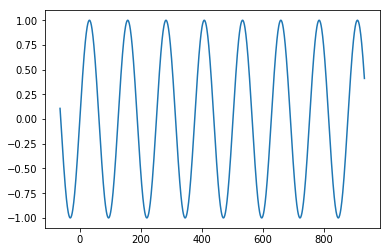

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(x[0], data[0])

## 2. 准备模型
这里使用了简单的lstm模型

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
class LstmPredict(nn.Module):
    def __init__(self):
        super(LstmPredict, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
#         将列表中的矩阵连在一起，并且将多余的维度去除
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [5]:
outputs = []
outputs += [1]
outputs += [4]
outputs

[1, 4]

In [6]:
input = torch.from_numpy(data[3:, :-1])
test1 = input[0:3,1:10]
test1

tensor([[-0.9738, -0.9840, -0.9917, -0.9969, -0.9996, -0.9998, -0.9975, -0.9927,
         -0.9854],
        [-0.1987, -0.1494, -0.0998, -0.0500,  0.0000,  0.0500,  0.0998,  0.1494,
          0.1987],
        [ 0.9490,  0.9636,  0.9757,  0.9854,  0.9927,  0.9975,  0.9998,  0.9996,
          0.9969]], dtype=torch.float64)

In [7]:
lists = []
for i in test1.chunk(test1.size(1), dim=1):
        print(i)
        lists.append(i)
print(lists)
torch.stack(lists, 1).squeeze(2)

tensor([[-0.9738],
        [-0.1987],
        [ 0.9490]], dtype=torch.float64)
tensor([[-0.9840],
        [-0.1494],
        [ 0.9636]], dtype=torch.float64)
tensor([[-0.9917],
        [-0.0998],
        [ 0.9757]], dtype=torch.float64)
tensor([[-0.9969],
        [-0.0500],
        [ 0.9854]], dtype=torch.float64)
tensor([[-0.9996],
        [ 0.0000],
        [ 0.9927]], dtype=torch.float64)
tensor([[-0.9998],
        [ 0.0500],
        [ 0.9975]], dtype=torch.float64)
tensor([[-0.9975],
        [ 0.0998],
        [ 0.9998]], dtype=torch.float64)
tensor([[-0.9927],
        [ 0.1494],
        [ 0.9996]], dtype=torch.float64)
tensor([[-0.9854],
        [ 0.1987],
        [ 0.9969]], dtype=torch.float64)
[tensor([[-0.9738],
        [-0.1987],
        [ 0.9490]], dtype=torch.float64), tensor([[-0.9840],
        [-0.1494],
        [ 0.9636]], dtype=torch.float64), tensor([[-0.9917],
        [-0.0998],
        [ 0.9757]], dtype=torch.float64), tensor([[-0.9969],
        [-0.0500],
        [ 

tensor([[-0.9738, -0.9840, -0.9917, -0.9969, -0.9996, -0.9998, -0.9975, -0.9927,
         -0.9854],
        [-0.1987, -0.1494, -0.0998, -0.0500,  0.0000,  0.0500,  0.0998,  0.1494,
          0.1987],
        [ 0.9490,  0.9636,  0.9757,  0.9854,  0.9927,  0.9975,  0.9998,  0.9996,
          0.9969]], dtype=torch.float64)

In [8]:
module = LstmPredict()
module

LstmPredict(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

模型看得还不是很懂，先往下看看怎么训练吧

## 3. 训练模型
input,target为

一组y值序列的索引为0-999

则input为data[0:999]

target为data[1:]

target刚好比input整体向后移动一位

In [10]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
# build the model
seq = LstmPredict()
# Casts all floating point parameters and buffers to double datatype.
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(15):
    print('STEP: ', i)
    def closure():
        """
        A closure that reevaluates the model and returns the loss.
        """
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
#         下面那句不懂
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()

STEP:  0
loss: 0.5023738122475343
loss: 0.4985663937943548
loss: 0.4790119606115378
loss: 0.44633490214842186
loss: 0.3540631025749376
loss: 0.2050701661768075
loss: 1.3960531561167326
loss: 0.03249441148471893
loss: 0.02993487583960165
loss: 0.028326821011534394
loss: 0.026830612218824084
loss: 0.023771201989989534
loss: 0.01890141350454454
loss: 0.010646818233205827
loss: 0.008725752090268477
loss: 0.007872181287777077
loss: 0.005477842749594509
loss: 0.00405193356406388
loss: 0.0027296227011592154
loss: 0.0015402652769808548
test loss: 0.0013000876156955329
STEP:  1
loss: 0.0012797646167827333
loss: 0.0011690554954717101
loss: 0.001149891601372685
loss: 0.0011288245291280919
loss: 0.0010630561341024901
loss: 0.0009564006443282839
loss: 0.0008210827589983926
loss: 0.0007670796029145844
loss: 0.0007294716423578408
loss: 0.0007246558169811028
loss: 0.0007206211393648597
loss: 0.0007126686053106532
loss: 0.000696131049876869
loss: 0.0006641101811541401
loss: 0.0006101210702274825
loss: 

In [11]:
pred = seq(test_input)

In [12]:
test_input

tensor([[ 0.1082,  0.0584,  0.0084,  ...,  0.5429,  0.5003,  0.4564],
        [-0.3894, -0.3429, -0.2955,  ..., -0.7614, -0.7281, -0.6929],
        [-0.2392, -0.2875, -0.3350,  ...,  0.2220,  0.1730,  0.1236]],
       dtype=torch.float64)

In [13]:
test_target

tensor([[ 0.0584,  0.0084, -0.0416,  ...,  0.5003,  0.4564,  0.4113],
        [-0.3429, -0.2955, -0.2474,  ..., -0.7281, -0.6929, -0.6560],
        [-0.2875, -0.3350, -0.3817,  ...,  0.1730,  0.1236,  0.0738]],
       dtype=torch.float64)

In [14]:
pred

tensor([[ 0.0888,  0.0548, -0.0065,  ...,  0.4994,  0.4556,  0.4107],
        [-0.4262, -0.3406, -0.2781,  ..., -0.7284, -0.6933, -0.6565],
        [-0.2755, -0.2954, -0.3477,  ...,  0.1735,  0.1242,  0.0746]],
       dtype=torch.float64, grad_fn=<SqueezeBackward1>)

In [15]:
pred[:, :-future]

tensor([], dtype=torch.float64, grad_fn=<SliceBackward>)

In [16]:
criterion(pred, test_target)

tensor(7.0616e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)

## 4. 测试模型

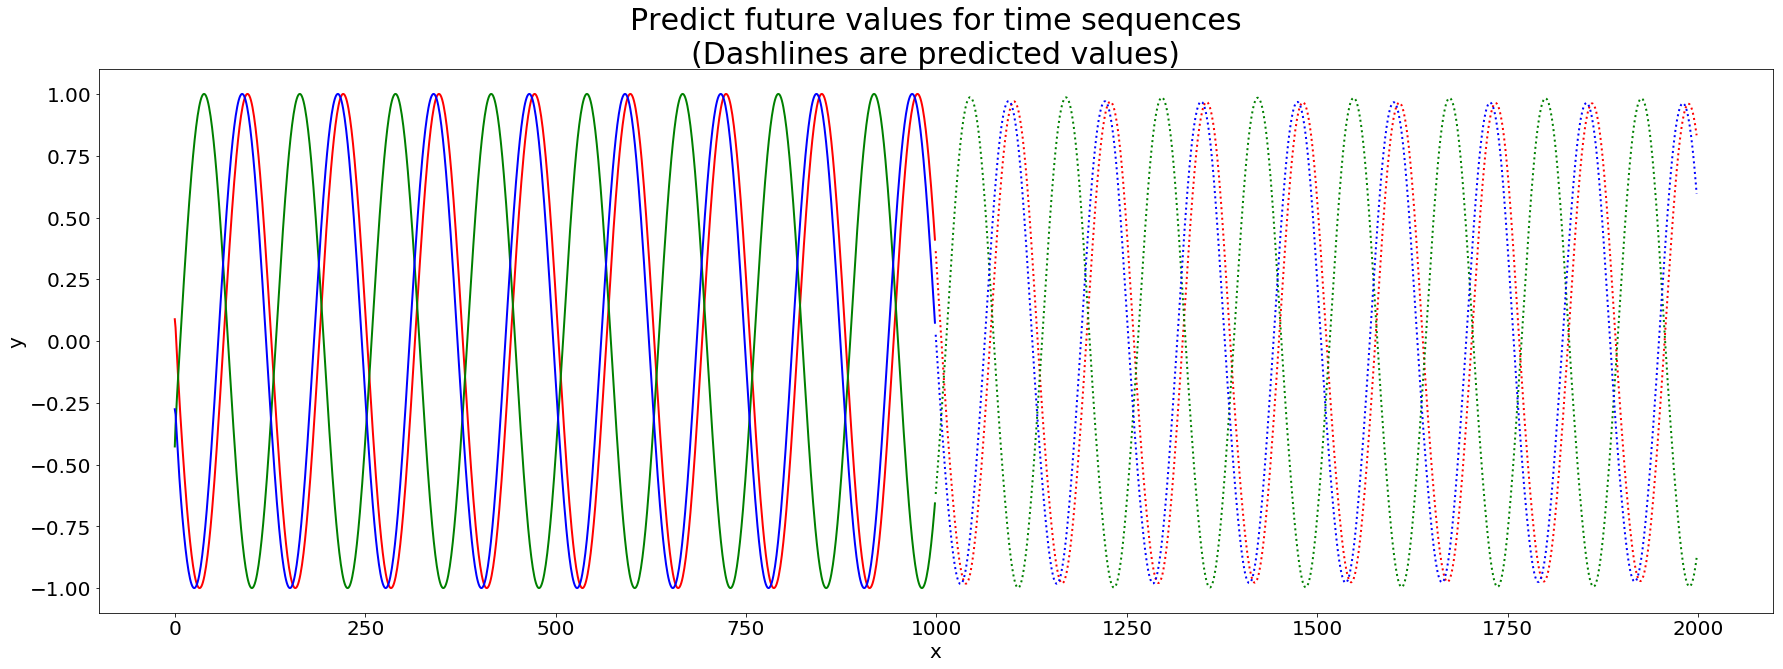

In [17]:
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')